<a href="https://colab.research.google.com/github/Jaya9522/almabetter_assignments/blob/main/Handling_Class_Imbalance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Let’s say we have a dataset of credit card companies where we have to find out whether the credit card transaction was fraudulent or not.

But here’s the catch… the fraud transaction is relatively rare, only 6% of the transaction is fraudulent.

Now, before you even start, do you see how the problem might break? Imagine if you didn’t bother training a model at all. Instead, what if you just wrote a single line of code that always predicts ‘no fraudulent transaction’.

```
def transaction(transaction_data):
    return 'No fradulent transaction'
```







Well, guess what? Your “solution” would have 94% accuracy!

Unfortunately, that accuracy is misleading.

* All those non-fraudulent transactions, you’d have 100% accuracy.
* Those transactions which are fraudulent, you’d have 0% accuracy.
* Your overall accuracy would be high simply because the most transaction is not fraudulent(not because your model is any good).

This is clearly a problem because many machine learning algorithms are designed to maximize overall accuracy.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data = pd.read_csv('/content/drive/MyDrive/DATA SET/creditcard.csv')

In [4]:
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,V29,Target
0,0.114697,0.796303,-0.149553,-0.823011,0.878763,-0.553152,0.939259,-0.108502,0.111137,-0.390521,...,-0.335776,-0.807853,-0.055940,-1.025281,-0.369557,0.204653,0.242724,0.085713,0.89,0
1,-0.039318,0.495784,-0.810884,0.546693,1.986257,4.386342,-1.344891,-1.743736,-0.563103,-0.616315,...,-1.377003,-0.072200,-0.197573,1.014807,1.011293,-0.167684,0.113136,0.256836,85.00,0
2,2.275706,-1.531508,-1.021969,-1.602152,-1.220329,-0.462376,-1.196485,-0.147058,-0.950224,1.560463,...,-0.193271,-0.103533,0.150945,-0.811083,-0.197913,-0.128446,0.014197,-0.051289,42.70,0
3,1.940137,-0.357671,-1.210551,0.382523,0.050823,-0.171322,-0.109124,-0.002115,0.869258,-0.001965,...,0.157994,0.650355,0.034206,0.739535,0.223605,-0.195509,-0.012791,-0.056841,29.99,0
4,1.081395,-0.502615,1.075887,-0.543359,-1.472946,-1.065484,-0.443231,-0.143374,1.659826,-1.131238,...,0.224157,0.821209,-0.137223,0.986259,0.563228,-0.574206,0.089673,0.052036,68.00,0


In [5]:
data['Target'].value_counts()

0    56864
1       98
Name: Target, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


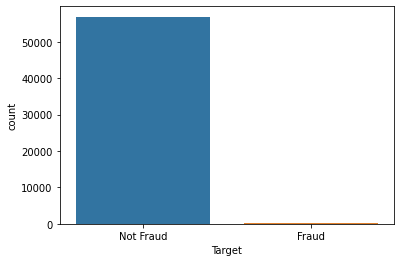

In [6]:
# visualize the target variable
g = sns.countplot(data['Target'])
g.set_xticklabels(['Not Fraud','Fraud'])
plt.show()

## The Metric Trap

One of the major issues when dealing with unbalanced datasets relates to the metrics used to evaluate their model. Using simpler metrics like accuracy score can be misleading. In a dataset with highly unbalanced classes, the classifier will always “predict” the most common class without performing any analysis of the features and it will have a high accuracy rate, obviously not the correct one.

Let’s do this experiment, using simple XGBClassifier and no feature engineering:

In [7]:
# Creating the dataset with all independent variables
X = data.iloc[:,:-1]

# Creating the dataset with the dependent variable
Y = data.iloc[:,-1]

In [8]:
# Splitting the dataset into the Training set and Test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 3)

In [9]:
print("Distribution of classes of dependent variable in train :")
print(Y_train.value_counts())

print("\n Distribution of classes of dependent variable in test :")
print(Y_test.value_counts())

Distribution of classes of dependent variable in train :
0    45492
1       77
Name: Target, dtype: int64

 Distribution of classes of dependent variable in test :
0    11372
1       21
Name: Target, dtype: int64


In [10]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
classifier.fit(X_train, Y_train)

KNeighborsClassifier()

In [11]:
y_pred = classifier.predict(X_test)

In [12]:
accuracy_score(y_pred, Y_test)

0.9987711752830686

In [13]:
confusion_matrix(y_pred, Y_test)

array([[11371,    13],
       [    1,     8]])

In [14]:
roc_auc_score(y_pred, Y_test)

0.9438734676348871

# Resampling Techniques

A widely adopted technique for dealing with highly unbalanced datasets is called resampling. It consists of removing samples from the majority class (under-sampling) and/or adding more examples from the minority class (over-sampling).

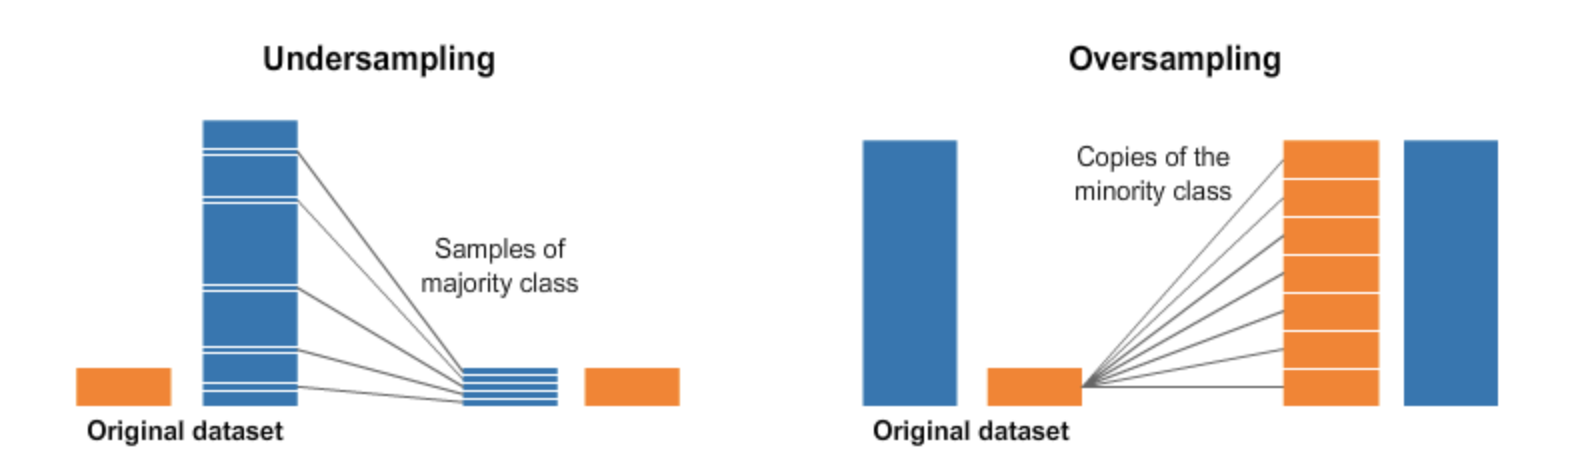

Despite the advantage of balancing classes, these techniques also have their own weaknesses.

The simplest implementation of over-sampling is to duplicate random records from the minority class, which can cause overfitting.

In under-sampling, the simplest technique involves removing random records from the majority class, which can cause loss of information.



Let’s implement this with the credit card fraud detection example.

We will start by separating the class that will be 0 and class 1.

In [15]:
# Class count
class_count_0, class_count_1 = data['Target'].value_counts()

# Separate class
class_0 = data[data['Target'] == 0]
class_1 = data[data['Target'] == 1]
print('class 0:', class_0.shape)
print('class 1:', class_1.shape)

class 0: (56864, 30)
class 1: (98, 30)


# 1. Random Under-Sampling

Undersampling can be defined as removing some observations of the majority class. This is done until the majority and minority class is balanced out.

Undersampling can be a good choice when you have a ton of data -think millions of rows. But a drawback to undersampling is that we are removing information that may be valuable.

In [16]:
class_0_under = class_0.sample(class_count_1)
test_under = pd.concat([class_0_under, class_1], axis=0)

In [17]:
test_under['Target'].value_counts()

0    98
1    98
Name: Target, dtype: int64

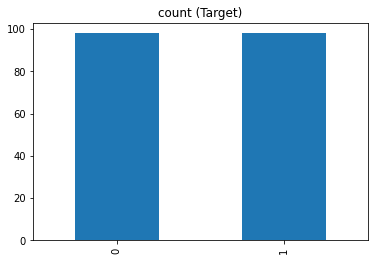

In [18]:
test_under['Target'].value_counts().plot(kind='bar', title='count (Target)')

In [19]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42, replacement=True)
x_rus, y_rus = rus.fit_resample(data.iloc[:,0:-1], data['Target'])

print('Original dataset shape:', len(data))
print('Resampled dataset shape', len(y_rus))

Original dataset shape: 56962
Resampled dataset shape 196


# 2. Random Over-Sampling

Oversampling can be defined as adding more copies to the minority class. Oversampling can be a good choice when you don’t have a ton of data to work with.

A con to consider when undersampling is that it can cause overfitting and poor generalization to your test set.

In [20]:
class_1_over = class_1.sample(class_count_0, replace=True)
test_over = pd.concat([class_1_over, class_0], axis=0)

In [21]:
test_over['Target'].value_counts()

1    56864
0    56864
Name: Target, dtype: int64

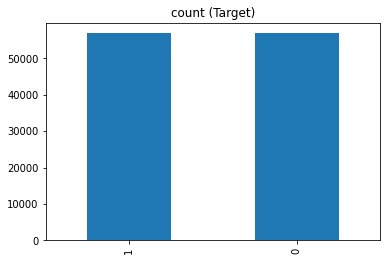

In [22]:
test_over['Target'].value_counts().plot(kind='bar', title='count (Target)')

In [23]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
x_ros, y_ros = ros.fit_resample(data.iloc[:,0:-1], data['Target'])

print('Original dataset shape:', len(data))
print('Resampled dataset shape', len(y_ros))

Original dataset shape: 56962
Resampled dataset shape 113728


# 3. Under-Sampling: Tomek links

Tomek links are pairs of very close instances but of opposite classes. Removing the instances of the majority class of each pair increases the space between the two classes, facilitating the classification process.

Tomek’s link exists if the two samples are the nearest neighbors of each other.

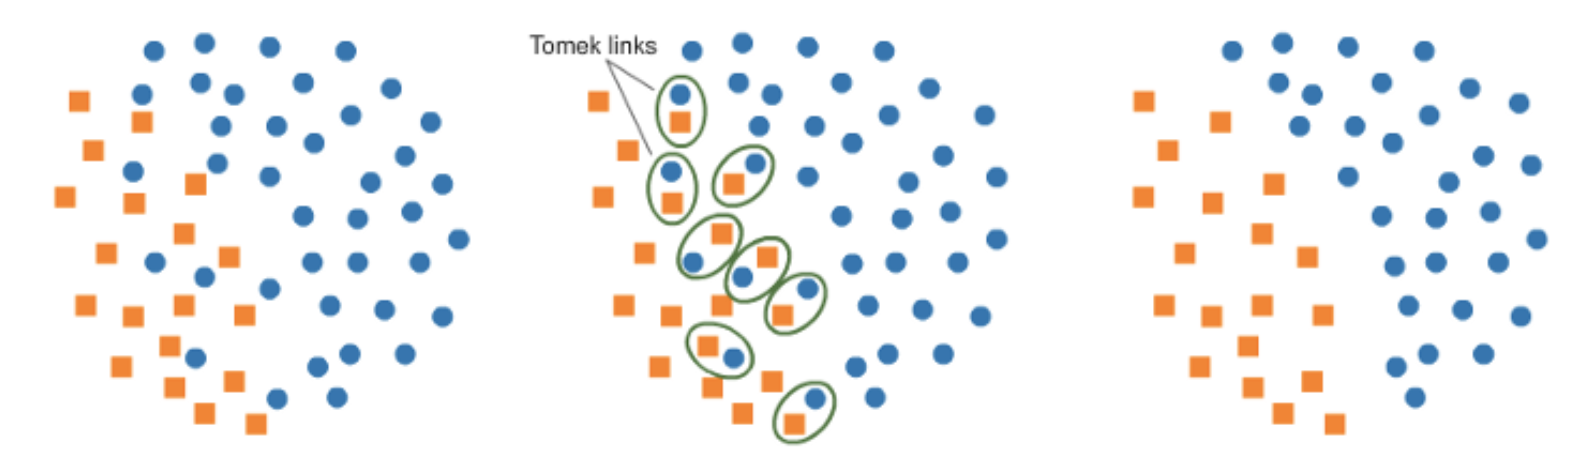

In [24]:
from imblearn.under_sampling import TomekLinks

tl = TomekLinks(ratio='majority')

X_tl, y_tl = tl.fit_sample(data.iloc[:,0:-1], data['Target'])

print('Original dataset shape:', len(data))
print('Resampled dataset shape', len(y_tl))

TypeError: ignored

# 4. Synthetic Minority Oversampling Technique (SMOTE)

This technique generates synthetic data for the minority class.

SMOTE (Synthetic Minority Oversampling Technique) works by randomly picking a point from the minority class and computing the k-nearest neighbors for this point. The synthetic points are added between the chosen point and its neighbors.

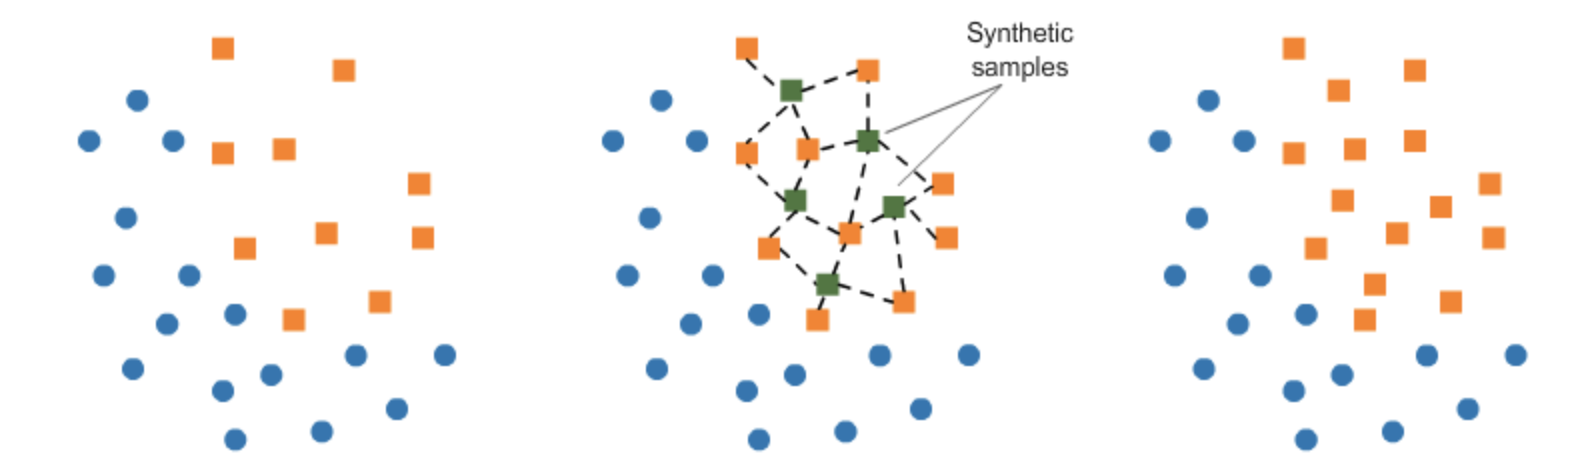

SMOTE algorithm works in 4 simple steps:

* Choose a minority class as the input vector
* Find its k nearest neighbors (k_neighbors is specified as an argument in the SMOTE() function)
* Choose one of these neighbors and place a synthetic point anywhere on the line joining the point under consideration and its chosen neighbor
* Repeat the steps until data is balanced

In [25]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()

# fit predictor and target variable
x_smote, y_smote = smote.fit_resample(data.iloc[:,0:-1], data['Target'])

print('Original dataset shape', len(data))
print('Resampled dataset shape', len(y_smote))

Original dataset shape 56962
Resampled dataset shape 113728


# 5. Penalize Algorithms (Cost-Sensitive Training)

The next tactic is to use penalized learning algorithms that increase the cost of classification mistakes on the minority class.

A popular algorithm for this technique is Penalized-SVM.

During training, we can use the argument `class_weight=’balanced’` to penalize mistakes on the minority class by an amount proportional to how under-represented it is.


In [ ]:
from sklearn.svm import SVC

# we can add class_weight='balanced' to add penalize mistake
svc_model = SVC(class_weight='balanced', probability=True)

svc_model.fit(X_train, Y_train)

svc_predict = svc_model.predict(X_test)
print('ROCAUC score:',roc_auc_score(Y_test, svc_predict))
print('Accuracy score:',accuracy_score(Y_test, svc_predict))

**But what happens exactly in the background?**

Let's take the loss function of logistic regression:

`Loss = −ylog(p) − (1−y)log(1−p)`

In this particular form, we give equal weight to both the positive and the negative classes. When we set class_weight as `class_weight = {0:1,1:20}`, the classifier in the background tries to minimize:

```
NewLoss = −20*ylog(p) − 1*(1−y)log(1−p)
```



**So what happens exactly here?**
* If our model gives a probability of 0.3 and we misclassify a positive example, the NewLoss acquires a value of -20log(0.3) = 10.45
* If our model gives a probability of 0.7 and we misclassify a negative example, the NewLoss acquires a value of -log(0.3) = 0.52

That means we penalize our model around twenty times more when it misclassifies a positive minority example in this case.

# 6. Try Tree Based Algorithms

While in every machine learning problem, it’s a good rule of thumb to try a variety of algorithms, it can be especially beneficial with imbalanced datasets.

Decision trees frequently perform well on imbalanced data. In modern machine learning, tree ensembles (Random Forests, Gradient Boosted Trees, etc.) almost always outperform singular decision trees, so we’ll jump right into those:

Tree base algorithm work by learning a hierarchy of if/else questions. This can force both classes to be addressed.

In [ ]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier().fit(X_train, Y_train)

# predict
xgb_y_predict = xgb_model.predict(X_test)

print('ROCAUC score:', roc_auc_score(Y_test, xgb_y_predict))
print('Accuracy score:', accuracy_score(Y_test, xgb_y_predict))

ROCAUC score: 0.8808204780329296
Accuracy score: 0.9992978144474678


# Choose the evaluation metric wisely

Accuracy is not the best metric to use when evaluating imbalanced datasets as it can be misleading.

Metrics that can provide better insight are:

* **Confusion Matrix**: a table showing correct predictions and types of incorrect predictions.
* **Precision**: the number of true positives divided by all positive predictions. Precision is also called Positive Predictive Value. It is a measure of a classifier’s exactness. Low precision indicates a high number of false positives.
* **Recall**: the number of true positives divided by the number of positive values in the test data. The recall is also called Sensitivity or the True Positive Rate. It is a measure of a classifier’s completeness. Low recall indicates a high number of false negatives.
* **F1 Score**: the weighted average of precision and recall.
* **Area Under ROC Curve (AUC-ROC)**: AUC-ROC represents the likelihood of your model distinguishing observations from two classes. In other words, if you randomly select one observation from each class, what’s the probability that your model will be able to “rank” them correctly?

# Let's use SMOTE + Deep Neural Network to solve this!

In [ ]:
# Splitting the dataset into the Training set and Test set
x_train, x_test, y_train, y_test = train_test_split(x_smote, y_smote, test_size = 0.2, random_state = 3)

In [ ]:
# DNN
from tensorflow import keras

def get_model():
    model = keras.Sequential([
        keras.layers.Flatten(input_shape=[X_train.shape[-1]]),
        keras.layers.Dense(512, activation='relu'),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(9, activation='softmax')
    ])
    model.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
# DNN (fit and validation)
import tensorflow as tf

batch_size = 512
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(len(x_train)).batch(batch_size)
val_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

model = get_model()
fit = model.fit(train_ds, validation_data=val_ds, epochs=20)

Epoch 1/20
178/178 [==============================] - 4s 20ms/step - loss: 0.8291 - accuracy: 0.7752 - val_loss: 0.0328 - val_accuracy: 0.9893
Epoch 2/20
178/178 [==============================] - 3s 19ms/step - loss: 0.0756 - accuracy: 0.9759 - val_loss: 0.0322 - val_accuracy: 0.9903
Epoch 3/20
178/178 [==============================] - 3s 19ms/step - loss: 0.0579 - accuracy: 0.9836 - val_loss: 0.0351 - val_accuracy: 0.9868
Epoch 4/20
178/178 [==============================] - 3s 19ms/step - loss: 0.2044 - accuracy: 0.9568 - val_loss: 0.0330 - val_accuracy: 0.9924
Epoch 5/20
178/178 [==============================] - 3s 19ms/step - loss: 0.0457 - accuracy: 0.9818 - val_loss: 0.0193 - val_accuracy: 0.9914
Epoch 6/20
178/178 [==============================] - 4s 20ms/step - loss: 0.0275 - accuracy: 0.9887 - val_loss: 0.0230 - val_accuracy: 0.9870
Epoch 7/20
178/178 [==============================] - 3s 19ms/step - loss: 0.0330 - accuracy: 0.9896 - val_loss: 0.0195 - val_accuracy: 0.9932

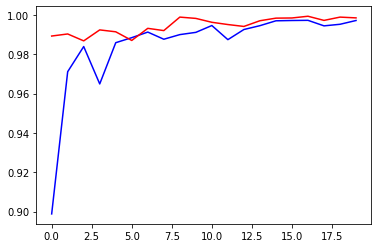

In [ ]:
import matplotlib.pyplot as plt

plt.plot(fit.history['accuracy'], color='blue')
plt.plot(fit.history['val_accuracy'], color='red')
plt.show()

In [ ]:
y_pred_nn = model.predict_classes(val_ds)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
print('ROCAUC score:', roc_auc_score(y_test, y_pred_nn))
print('Accuracy score:', accuracy_score(y_test, y_pred_nn))

ROCAUC score: 0.998494885633584
Accuracy score: 0.9985052316890882


# That looks great! Fraudsters, here I come!